---
layout: default
title: "Deep Learning - CNN - Object detection"
categories: deeplearning
permalink: /ML37/
order: 37
comments: true
---

In [24]:
%pylab --no-import-all inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
from plot_ann import ann
plt.rcParams["mathtext.fontset"] = "cm"
import pandas as pd
import sklearn.datasets
from matplotlib import cm
from matplotlib import animation, rc
from IPython.display import HTML
from matplotlib.patches import Rectangle

Populating the interactive namespace from numpy and matplotlib


# Object detection
Object detection is one of the area that has improved more in the last few years. The first step towards object detection is **object localization**.

## Object localization
Image classification is the problem of predicting the class of an object shown in a picture. A task of image classification with localization produces a predicted label for the image and also finds the exact location of the labeled object within the image. Finding the location of an object means defining a **bounding box** that contains the recognized object. Finally an object detection task detects multiple objects (even of different classes) in an image and all their locations.

To train a network on an object localization task we can build on the image classification architectures that we have seen so far. Suppose we have a network for an image classification task that needs to distinguish 3 classes: flower, leaf, background (none of the two). We would have input images, fed into a CNN with some convolutional layers and some final fully connected layers that terminates with a softmax regression layer with 3 hidden units. In order to train a network to localize the classified object we need 4 additional output units: $b_x$, $b_y$, $b_h$, $b_w$. These 4 numbers parameterize the bounding box of the detected object.

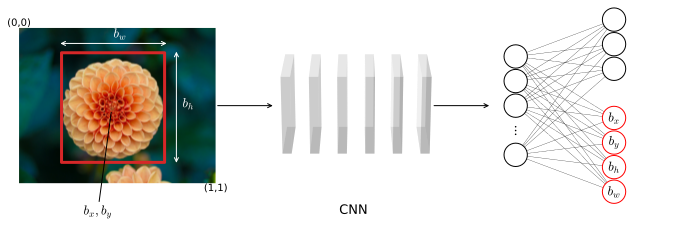

In [2]:
fig = plt.figure(figsize=(12, 4))
gs = fig.add_gridspec(1, 3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], projection='3d')
ax3 = fig.add_subplot(gs[0, 2])

ax1.imshow(sklearn.datasets.load_sample_images().images[1][:, 50:-50, :])

x, y, z = np.indices((1,16,1))
l1 = (x >= 0) & (y == 0) & (z >= 0)
l2 = (x >= 0) & (y == 3) & (z >= 0)
l3 = (x >= 0) & (y == 6) & (z >= 0)
l4 = (x >= 0) & (y == 9) & (z >= 0)
l5 = (x >= 0) & (y == 12) & (z >= 0)
l6 = (x >= 0) & (y == 15) & (z >= 0)

ax2.voxels(l1 | l2 | l3 | l4 | l5 | l6, edgecolor='none', facecolors='w', alpha=.3)
ax2.set_box_aspect([1, 2, 1])
ax2.view_init(elev=20, azim=0)
ax2.text2D(0.5, 0, 'CNN', fontsize=13, transform=ax2.transAxes, ha='center', va='top')

ann([ 5, 8], ax=ax3, radius=1.9, node_labels=[*[*'   ', '$\\vdots$', *'     ', '$b_x$', '$b_y$', '$b_h$', '$b_w$']], 
    node_colors=list('kkkwkkkkwrrrr'), edge_colors=list('kkkwkkkk'*3+'w'*8+'kkkwkkkk'), node_fontsize=13)
ax3.set_aspect('equal')

ax1.annotate(' ', (0, 0), (0.47, 0.47), textcoords=ax1.transAxes, bbox=dict(boxstyle='square', pad=5, fc='none', edgecolor='C3', linewidth=3))
ax1.annotate('$b_x, b_y$', (0.47, 0.47), (0.4, -.2), xycoords=ax1.transAxes, textcoords=ax1.transAxes, ha='center', fontsize=13, arrowprops=dict(arrowstyle='-'))
ax2.annotate('', (0.1, 0.5), (1, 0.5), xycoords=ax2.transAxes, textcoords=ax1.transAxes, arrowprops=dict(arrowstyle='->'))
ax2.annotate('', (0, 0.5), (0.9, 0.5), xycoords=ax3.transAxes, textcoords=ax2.transAxes, arrowprops=dict(arrowstyle='->'))
ax1.text(0, 1, '(0,0)', va='bottom', ha='center', transform=ax1.transAxes)
ax1.text(1, 0, '(1,1)', va='top', ha='center', transform=ax1.transAxes)
h = ax1.annotate('', (0.8, 0.12), (0.8, 0.86), xycoords=ax1.transAxes, textcoords=ax1.transAxes, arrowprops=dict(arrowstyle='<->', edgecolor='w'))
ax1.annotate('$b_h$', (0, 0), (2, 0.5), textcoords=h.arrow_patch, fontsize=13, c='w')
w = ax1.annotate('', (0.2, 0.9), (0.76, 0.9), xycoords=ax1.transAxes, textcoords=ax1.transAxes, arrowprops=dict(arrowstyle='<->', edgecolor='w'))
ax1.annotate('$b_w$', (0, 0), (0.5, 2), textcoords=w.arrow_patch, fontsize=13, c='w')

for ax in [ax1, ax2, ax3]:
    ax.set_axis_off()

<i id="fig:cnnloc">Simplified architecture of a CNN trained on a task of object localization. It takes as input an image, whose representation passes through some convolutional layers and finally to some densely connected layers. The output layers has 4 units dedicated to parameterize the bounding box for localization, with $b_x$, $b_y$ (the coordinates of the midpoint of the bounding box) and $b_w$, $b_h$ (the width and height of the bounding box)</i>

A CNN trained on a localization task needs a labeled training set with the four parameters of the bounding box defined for each example. In particular the label vector $y$ will be:

$$
y=
\begin{bmatrix}
p_c \\
b_x \\ 
b_y \\
b_h \\
b_w \\
c_1 \\
c_2
\end{bmatrix}
$$

where $p_c$ is the probability that the picture contains an object (either 1 or 0), $b_x, b_y, b_w, b_h$ are the parameters of the bounding box and $c_1$ and $c_2$ are 1 if the object in the picture is class 1 or 2 respectively, otherwise they are 0. When $p_c=0$ we can ignore all other values of the label vector $y$, since the only feature that we care to learn is that in that image there is no object. This is reflected in the loss function $\mathcal{L}(\hat{y},y)$

$$
\mathcal{L}(\hat{y},y)=
\begin{cases} 
\sum_{i=1}^{c+4}(\hat{y}_i - y_i)^2 & \text{if } y_i = 1 \\
(\hat{y}_i - y_i)^2   & \text{if } y_i = 0 \\
\end{cases}
$$

Here squared error loss function is used for all labels where in reality squared error is used for the bounding box labels and $p_c$, while for the 2 class labels log loss is usually employed although probably using squared error would work just fine.

## Landmark detection
By expanding object localization to a more general case, we can train a neural network to output $x,y$ coordinates of relevant points (**landmarks**) in an image. Suppose we are building a face recognition application and we want to identify some important features of a face, as for example the eyes and the mouth. To train a network on the task to recognize these landmarks, the label vector $y$ would contain the eyes coordinates and mouth coordinates.

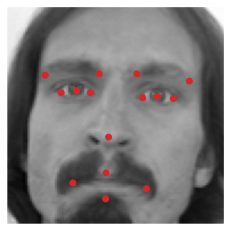

In [3]:
images = pd.read_csv('data/face_landmarks.csv', nrows=10, index_col=[0])
fig, ax = plt.subplots()
ax.imshow(np.array(images.Image.values[0].split(), dtype=float).reshape(96, 96, 1), cmap='gray')
xy = images.drop('Image', axis=1).loc[0]
ax.plot(xy[::2], xy[1::2], ls='none', marker='o', c='C3')
ax.set_axis_off()

<i id="fig:landmarks">Some face landmarks drawn in red over a grayscale face picture</i>

Obviously, in order to train a neural network to output landmark coordinates it has to be trained on a labeled dataset, which needs to be laboriously and precisely annotated for each landmark in each picture. 

In <a href="#fig:landmarks">the figure above</a> we can see a typical set of landmarks for face-oriented tasks. Another example of landmark detection not applyed to face pictures is pose detection where landmarks usually reflect body joints (e.g. shoulder, knee) that, connected toghether, form a sort of skeleton of a person.

## Object detection
A convnet can be trained on object detection using a technique called **sliding window detection**. Suppose we want to train an algorithm for a self-driving car, which should be able to detect multiple type of objects and multiple instances of objects in a picture (<a href="fig:cardetect">figure below</a>).

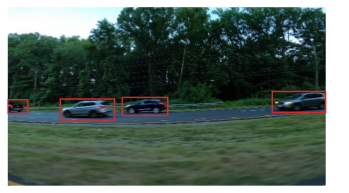

In [4]:
fig, ax = plt.subplots()
img = plt.imread('./data/img/vid_4_9620.jpg')
ax.imshow(img)
ax.set_axis_off()

bbox = pd.read_csv('./data/bbox.csv', index_col=0)
for row in bbox.loc['vid_4_9620.jpg'].iterrows():
    ax.plot(row[1][['xmin', 'xmin', 'xmax', 'xmax', 'xmin']],
            row[1][['ymin', 'ymax', 'ymax', 'ymin', 'ymin']], c='C3')

<i id="fig:cardetect">A frame of a video-feed with multiple cars correctly localized by an  object detection algorithm</i>

In order to obtain an object detection capable neural network, we need to train it on a training where each example is a picture of a closely cropped car (<a href="fig:objdettrainset">figure below</a>) and the label simply tells if the picture contains a car or not. 

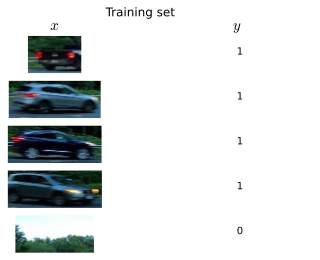

In [5]:
fig, axes = plt.subplots(5, 2)
fig.suptitle('Training set')
img = plt.imread('./data/img/vid_4_9620.jpg')
bbox = pd.read_csv('./data/bbox.csv', index_col=0)

axes[0, 0].set_title('$x$', fontsize=15)
for ax, row in zip(axes[:, 0], bbox.loc['vid_4_9620.jpg'].iterrows()):
    ax.imshow(img)
    ax.set_axis_off()
    ax.set_xlim(*row[1][['xmax', 'xmin']])
    ax.set_ylim(*row[1][['ymax', 'ymin']])

axes[-1, 0].imshow(img)
axes[-1, 0].set_xlim(200, 0)
axes[-1, 0].set_ylim(100, 5)
axes[-1, 0].set_axis_off()

    
axes[0, 1].set_title('$y$', fontsize=15)
for ax in axes[:-1, 1]:
    ax.set_axis_off()
    ax.text(0.5, 0.5, '1')
axes[-1, 1].text(0.5, 0.5, '0')
axes[-1, 1].set_axis_off()

<i id="fig:objdettrainset">Training set for an object detection algorithm with closely cropped images of the object of interest</i>

The next would be to train a CNN that takes as input a picture and tells if the picture is  a car $\hat{y}=1$ or not $\hat{y}=0$. Once trained, this CNN is used in a **sliding window detection** system, the CNN is fed a n image bound by a box that rolls over the image from left to right and from top to bottom.

In [85]:
%%capture
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax1, ax2 = axes
img = plt.imread('./data/img/vid_4_9620.jpg')
h, w, _ = img.shape
im = ax1.imshow(img)
h_steps = 10
w_steps = 10
r = Rectangle((0, 0), w/w_steps, h/h_steps, facecolor='none', edgecolor='r', linewidth=2)
ax1.set_axis_off()

In [86]:
def init():
    ax1.add_artist(r)
    return [r]

def animate(i):
    x = (w/w_steps) * (i)
    y = (h/h_steps) * (x//w)
    x %= w
    r.set_xy((x, y))
    return [r]

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=h_steps * w_steps, interval=100, 
                               blit=True)

HTML(anim.to_html5_video())